## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

# Local imports from model.py, data.py
from model import CovidModel, Compartments, LogPoissonProb, get_logging_callbacks
from data import read_data, create_warmup
from plots import make_all_plots

2021-09-30 06:08:12.639466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-30 06:08:12.639496: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Controllable Parameters

### Data details

In [2]:
warmup_start = '20210401'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = './data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_rho_in_warmup_0'

### Model Settings

In [3]:
# How long can a person take to progress?
transition_window = 20

# CovidEstim Hyper param
T_serial = 5.8

### Vaccine efficacy for incorrect warmup data split

In [4]:
# Vaccines are 90% effective at preventing infection
# according to a study of 4000 healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7013e3.htm
vax_asymp_risk = 0.90
# Vaccines are 94% effective at preventing symptomatic
# according to a study of healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7020e2.htm
vax_mild_risk = 0.94
vax_extreme_risk = 0.94
# Vaccines are 94% effective at preventing hospitalization
# according to a study of adults over 65 early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7018e1.htm?s_cid=mm7018e1_w
vax_general_ward_risk = 0.94 # not used

### Model prior parameters

In [5]:
# Parameters for the Beta distribution prior over rho, the probablility that
# someone progresses to the next state. Here we use a uniform distribution
# for all compartments, but we could specify a different prior for each M, X, G

# Copied from covid estim
# covidestim infected -> symptoms
alpha_bar_M = 5.5
beta_bar_M = 3.53
# covidestim symptoms -> severe
alpha_bar_X = 1.89
beta_bar_X = 20
# covid estim severe -> death
alpha_bar_G = 28.2
beta_bar_G = 162.3

# Parameters for the positive truncated Normal distribution prior over lambda, the rate
# parameter of the Poisson distribution controlling pi,
# which determines how quickly someone who progresses does so +
# Parameters for the positive truncated Normal distribution prior over nu, the parameter used
# to scale the poisson distribution governed by pi, allowing for a more expressive
# range of possible transition days

# We choose these values to match the gamma priors in covid estim
# Covidestim infected -> symptoms = Gamma(3.41, 0.61)
lambda_bar_M = 4.7
sigma_bar_M = 1.00
nu_bar_M = 1.70
tau_bar_M = 0.10

# Covidestim Symptoms -> severe = Gamma(1.72, 0.22)
lambda_bar_X = 4
sigma_bar_X = 0.5
nu_bar_X = 18
tau_bar_X = 8.1

# Covidestim severe -> death = Gamma(2.10, 0.23)
lambda_bar_G = 3.3
sigma_bar_G = 1
nu_bar_G = 9
tau_bar_G = 0.2


# Learning rate
learning_rate = 1e-1

## Read data

In [6]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [7]:
# Optional, replace covidestim warmup data with fixed constants
df.loc[:,'extreme'] = 7*df.loc[:,'general_ward']
df.loc[:,'mild'] = 10*df.loc[:,'extreme']
df.loc[:,'asymp'] = 1.5*df.loc[:,'mild']

## Create warmup using incorrect efficacy assumption

In [8]:
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          vax_asymp_risk,
                                                          vax_mild_risk,
                                                          vax_extreme_risk)

## Create training Rt and outcome

In [9]:
training_rt = df.loc[train_start:train_end,'Rt'].values
training_general_ward = df.loc[train_start:train_end,'general_ward'].values

# Start the model from the training period so we are continuous
testing_rt = df.loc[train_start:test_end,'Rt'].values
testing_general_ward = df.loc[train_start:test_end,'general_ward'].values

## Build Model

In [10]:
model = CovidModel(transition_window, T_serial,
                     alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                 lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                 nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_X, tau_bar_X)

2021-09-30 06:08:14.546739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-09-30 06:08:14.546984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-30 06:08:14.547018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-09-30 06:08:14.547045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-09-30 06:08:14.547071: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

## Fit model

In [11]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)

loss = LogPoissonProb()

model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
callbacks = get_logging_callbacks(log_dir)

2021-09-30 06:08:14.591840: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-30 06:08:14.591869: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-30 06:08:14.591923: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-09-30 06:08:14.592347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-09-30 06:08:14.592399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2021-09-30 06:08:14.592409: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

In [12]:
# Awkwardly stuff everything into an array

model.fit(x=(np.asarray([training_rt]),
       np.asarray([warmup_asymp[0]]), np.asarray([warmup_asymp[1]]),
       np.asarray([warmup_mild[0]+warmup_mild[1]]),
       np.asarray([warmup_extreme[0] +warmup_extreme[1]]),
       np.asarray([df.loc[warmup_start:warmup_end, 'vax_pct'].values])),
             y=np.asarray([training_general_ward]),
         epochs=500, batch_size=0, callbacks=callbacks)

2021-09-30 06:08:14.647273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
Eps loss-0.24097126722335815
Delta loss: -2.6758408546447754
Rho M loss 0: 7.220351219177246
Rho X loss 0: -1.1619853973388672
Rho G loss 0: 56.72553253173828
lam M loss 0: 0.918978214263916
lam X loss 0: 0.2264501452445984
lam G loss 0: 0.9191109538078308
nu M loss 0: 0.023960590362548828
nu X loss 0: 2.9975814819335938
nu G loss 0: 3.010802745819092
Rho M loss 1: 7.220351219177246
Rho X loss 1: -1.1619853973388672
Rho G loss 1: 56.72553253173828
lam M loss 1: 0.918978214263916
lam X loss 1: 0.2264501452445984
lam G loss 1: 0.9191109538078308
nu M loss 1: 0.023960590362548828
nu X loss 1: 2.9975814819335938
nu G loss 1: 3.010802745819092


2021-09-30 06:08:15.514159: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


1/1 [==============================] - 1s 1s/step - loss: 2444.8147
Epoch 2/500
Eps loss-0.23800307512283325
Delta loss: -2.680744171142578
Rho M loss 0: 6.972321510314941
Rho X loss 0: -1.236985683441162
Rho G loss 0: 54.13829803466797
lam M loss 0: 0.9247903227806091
lam X loss 0: 0.23857778310775757
lam G loss 0: 0.9272767305374146
nu M loss 0: -1.0316803455352783
nu X loss 0: 2.997657537460327
nu G loss 0: 3.0108790397644043
Rho M loss 1: 6.972321510314941
Rho X loss 1: -1.236985683441162
Rho G loss 1: 54.13829803466797
lam M loss 1: 0.9247893691062927
lam X loss 1: 0.2529035806655884
lam G loss 1: 0.9272767305374146
nu M loss 1: -1.0316803455352783
nu X loss 1: 2.997657537460327
nu G loss 1: 3.0108790397644043


2021-09-30 06:08:15.761064: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-30 06:08:15.761091: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-30 06:08:15.761197: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


1/1 [==============================] - ETA: 0s - loss: 2413.0063

2021-09-30 06:08:16.754822: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-30 06:08:16.756337: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-30 06:08:16.810535: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-30 06:08:16.933758: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-30 06:08:17.244653: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_09_30_06_08_16



1/1 [==============================] - 2s 2s/step - loss: 2413.0063


2021-09-30 06:08:17.499396: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_09_30_06_08_16/MrChipsNVME.trace.json.gz
2021-09-30 06:08:17.576197: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_09_30_06_08_16

2021-09-30 06:08:17.578557: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_09_30_06_08_16/MrChipsNVME.memory_profile.json.gz
2021-09-30 06:08:17.594734: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_09_30_06_08_16
Dumped tool data for xplane.pb to ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_09_30_06_08_16/MrChipsNVME.xplane.pb
Dumped tool data for overview_page.pb to ./lo

Epoch 3/500
Eps loss-0.23254519701004028
Delta loss: -2.685643196105957
Rho M loss 0: 6.725214958190918
Rho X loss 0: -1.3105878829956055
Rho G loss 0: 51.561119079589844
lam M loss 0: 0.9404445290565491
lam X loss 0: 0.23055922985076904
lam G loss 0: 0.9448540806770325
nu M loss 0: -1.3807451725006104
nu X loss 0: 2.9978864192962646
nu G loss 0: 3.0111076831817627
Rho M loss 1: 6.724797248840332
Rho X loss 1: -1.310619831085205
Rho G loss 1: 51.56206512451172
lam M loss 1: 0.9220280647277832
lam X loss 1: 0.23181825876235962
lam G loss 1: 0.944847047328949
nu M loss 1: -1.3810648918151855
nu X loss 1: 2.9978866577148438
nu G loss 1: 3.011107921600342
1/1 [==============================] - 1s 911ms/step - loss: 2379.3223
Epoch 4/500
Eps loss-0.2246077060699463
Delta loss: -2.6905384063720703
Rho M loss 0: 6.47965145111084
Rho X loss 0: -1.3826637268066406
Rho G loss 0: 48.99384307861328
lam M loss 0: 0.965991199016571
lam X loss 0: 0.22583222389221191
lam G loss 0: 0.9719377160072327
n

1/1 [==============================] - 1s 1s/step - loss: 1620.1803
Epoch 15/500
Eps loss0.020024657249450684
Delta loss: -2.743368625640869
Rho M loss 0: 5.128655433654785
Rho X loss 0: -2.017655849456787
Rho G loss 0: 21.508560180664062
lam M loss 0: 1.9566465616226196
lam X loss 0: 0.2909475564956665
lam G loss 0: 1.9025566577911377
nu M loss 0: -1.036353588104248
nu X loss 0: 3.012969970703125
nu G loss 0: 3.0258736610412598
Rho M loss 1: 3.82958984375
Rho X loss 1: -2.0191171169281006
Rho G loss 1: 21.760421752929688
lam M loss 1: 0.9662936329841614
lam X loss 1: 0.29594337940216064
lam G loss 1: 1.9044795036315918
nu M loss 1: -1.2171777486801147
nu X loss 1: 3.0133934020996094
nu G loss 1: 3.0261356830596924
1/1 [==============================] - 1s 972ms/step - loss: 1495.5582
Epoch 16/500
Eps loss0.05569654703140259
Delta loss: -2.7481181621551514
Rho M loss 0: 5.264537811279297
Rho X loss 0: -2.0516269207000732
Rho G loss 0: 19.13897705078125
lam M loss 0: 2.119014263153076
l

1/1 [==============================] - 1s 966ms/step - loss: 661.8137
Epoch 27/500
Eps loss0.38890212774276733
Delta loss: -2.786612033843994
Rho M loss 0: 6.4892578125
Rho X loss 0: -1.9428353309631348
Rho G loss 0: 1.1290359497070312
lam M loss 0: 2.6663930416107178
lam X loss 0: 3.23337984085083
lam G loss 0: 2.823604106903076
nu M loss 0: -0.7572369575500488
nu X loss 0: 3.052905321121216
nu G loss 0: 3.048894166946411
Rho M loss 1: 1.288172721862793
Rho X loss 1: -1.738004207611084
Rho G loss 1: -0.08426666259765625
lam M loss 1: 0.9210332036018372
lam X loss 1: 0.22854644060134888
lam G loss 1: 3.339837074279785
nu M loss 1: -1.3830703496932983
nu X loss 1: 3.0508646965026855
nu G loss 1: 3.0588035583496094
1/1 [==============================] - 1s 966ms/step - loss: 675.1542
Epoch 28/500
Eps loss0.3727356791496277
Delta loss: -2.784271717071533
Rho M loss 0: 6.316641807556152
Rho X loss 0: -1.9610841274261475
Rho G loss 0: 1.1268692016601562
lam M loss 0: 2.4878721237182617
lam 

1/1 [==============================] - 1s 975ms/step - loss: 396.2701
Epoch 39/500
Eps loss0.11111241579055786
Delta loss: -2.755845069885254
Rho M loss 0: 4.004709243774414
Rho X loss 0: -2.110041856765747
Rho G loss 0: 5.945259094238281
lam M loss 0: 1.120017647743225
lam X loss 0: 8.773580551147461
lam G loss 0: 1.48135507106781
nu M loss 0: -1.1241717338562012
nu X loss 0: 3.1253745555877686
nu G loss 0: 3.036982774734497
Rho M loss 1: -0.4269561767578125
Rho X loss 1: -1.0929827690124512
Rho G loss 1: -1.9559402465820312
lam M loss 1: 1.1610705852508545
lam X loss 1: 0.29200857877731323
lam G loss 1: 2.0147340297698975
nu M loss 1: -1.381922960281372
nu X loss 1: 3.0321967601776123
nu G loss 1: 3.0681350231170654
1/1 [==============================] - 1s 944ms/step - loss: 406.9968
Epoch 40/500
Eps loss0.10207313299179077
Delta loss: -2.7553391456604004
Rho M loss 0: 3.895414352416992
Rho X loss 0: -2.1092238426208496
Rho G loss 0: 6.080894470214844
lam M loss 0: 1.072358727455139

1/1 [==============================] - 1s 947ms/step - loss: 351.8572
Epoch 51/500
Eps loss0.15162700414657593
Delta loss: -2.767824172973633
Rho M loss 0: 4.016816139221191
Rho X loss 0: -2.107424020767212
Rho G loss 0: 3.4291915893554688
lam M loss 0: 0.9225828647613525
lam X loss 0: 3.704855442047119
lam G loss 0: 0.9526005983352661
nu M loss 0: -1.0679659843444824
nu X loss 0: 3.187567710876465
nu G loss 0: 3.0247485637664795
Rho M loss 1: -0.5515389442443848
Rho X loss 1: -1.2705445289611816
Rho G loss 1: -2.6261062622070312
lam M loss 1: 1.0258866548538208
lam X loss 1: 0.9805221557617188
lam G loss 1: 1.2263689041137695
nu M loss 1: -1.3800615072250366
nu X loss 1: 3.0542359352111816
nu G loss 1: 3.0780224800109863
1/1 [==============================] - 1s 944ms/step - loss: 346.4061
Epoch 52/500
Eps loss0.16107946634292603
Delta loss: -2.769775867462158
Rho M loss 0: 4.058684349060059
Rho X loss 0: -2.105072498321533
Rho G loss 0: 3.0728225708007812
lam M loss 0: 0.927881658077

1/1 [==============================] - 1s 945ms/step - loss: 341.1658
Epoch 63/500
Eps loss0.13967257738113403
Delta loss: -2.784003973007202
Rho M loss 0: 3.216127395629883
Rho X loss 0: -2.099301338195801
Rho G loss 0: 2.1264114379882812
lam M loss 0: 1.2118324041366577
lam X loss 0: 1.4804577827453613
lam G loss 0: 1.0783298015594482
nu M loss 0: -1.259867548942566
nu X loss 0: 3.27108097076416
nu G loss 0: 3.012932062149048
Rho M loss 1: -0.6676597595214844
Rho X loss 1: -1.430952548980713
Rho G loss 1: -2.7031936645507812
lam M loss 1: 0.9363828897476196
lam X loss 1: 0.30166304111480713
lam G loss 1: 0.9539958834648132
nu M loss 1: -1.3830066919326782
nu X loss 1: 3.059154510498047
nu G loss 1: 3.07930850982666
1/1 [==============================] - 1s 945ms/step - loss: 338.7672
Epoch 64/500
Eps loss0.12881463766098022
Delta loss: -2.7847132682800293
Rho M loss 0: 3.049830436706543
Rho X loss 0: -2.1010682582855225
Rho G loss 0: 2.2152175903320312
lam M loss 0: 1.260892510414123

1/1 [==============================] - 1s 945ms/step - loss: 329.0372
Epoch 75/500
Eps loss0.06153196096420288
Delta loss: -2.799874782562256
Rho M loss 0: 1.6892318725585938
Rho X loss 0: -2.1077027320861816
Rho G loss 0: 2.362762451171875
lam M loss 0: 1.9032917022705078
lam X loss 0: 1.5278034210205078
lam G loss 0: 1.8367109298706055
nu M loss 0: -1.374549388885498
nu X loss 0: 3.3824338912963867
nu G loss 0: 3.013279914855957
Rho M loss 1: -0.714240550994873
Rho X loss 1: -0.9526910781860352
Rho G loss 1: -2.7290496826171875
lam M loss 1: 0.9599809050559998
lam X loss 1: 0.23003244400024414
lam G loss 1: 0.9289097785949707
nu M loss 1: -1.383361577987671
nu X loss 1: 3.0520172119140625
nu G loss 1: 3.0809597969055176
1/1 [==============================] - 1s 947ms/step - loss: 327.7889
Epoch 76/500
Eps loss0.06212806701660156
Delta loss: -2.8020401000976562
Rho M loss 0: 1.6346979141235352
Rho X loss 0: -2.10752272605896
Rho G loss 0: 2.3005142211914062
lam M loss 0: 1.96355533599

1/1 [==============================] - 1s 938ms/step - loss: 319.8661
Epoch 87/500
Eps loss0.08937591314315796
Delta loss: -2.8233375549316406
Rho M loss 0: 1.0035972595214844
Rho X loss 0: -2.104203462600708
Rho G loss 0: 1.4817428588867188
lam M loss 0: 2.57283091545105
lam X loss 0: 1.3320410251617432
lam G loss 0: 2.791337013244629
nu M loss 0: -1.3534600734710693
nu X loss 0: 3.498961925506592
nu G loss 0: 3.0332491397857666
Rho M loss 1: -0.8216652870178223
Rho X loss 1: -1.1113367080688477
Rho G loss 1: -2.74200439453125
lam M loss 1: 0.9299633502960205
lam X loss 1: 0.2616158723831177
lam G loss 1: 0.922451913356781
nu M loss 1: -1.383296251296997
nu X loss 1: 3.043426513671875
nu G loss 1: 3.077193260192871
1/1 [==============================] - 1s 937ms/step - loss: 319.1910
Epoch 88/500
Eps loss0.08814579248428345
Delta loss: -2.824277400970459
Rho M loss 0: 0.8810768127441406
Rho X loss 0: -2.1044983863830566
Rho G loss 0: 1.4691085815429688
lam M loss 0: 2.6223809719085693

1/1 [==============================] - 1s 951ms/step - loss: 311.3351
Epoch 99/500
Eps loss0.10360878705978394
Delta loss: -2.816959857940674
Rho M loss 0: -0.27091360092163086
Rho X loss 0: -2.1076221466064453
Rho G loss 0: 1.3815383911132812
lam M loss 0: 3.0038979053497314
lam X loss 0: 0.9050638675689697
lam G loss 0: 3.6530237197875977
nu M loss 0: -1.3755314350128174
nu X loss 0: 3.619157314300537
nu G loss 0: 3.072876214981079
Rho M loss 1: -0.8157415390014648
Rho X loss 1: -1.0455846786499023
Rho G loss 1: -2.7484970092773438
lam M loss 1: 0.9190018773078918
lam X loss 1: 0.22586268186569214
lam G loss 1: 0.930869996547699
nu M loss 1: -1.3836338520050049
nu X loss 1: 3.0363166332244873
nu G loss 1: 3.074903726577759
1/1 [==============================] - 1s 917ms/step - loss: 310.8094
Epoch 100/500
Eps loss0.10887390375137329
Delta loss: -2.812808036804199
Rho M loss 0: -0.33996009826660156
Rho X loss 0: -2.107743263244629
Rho G loss 0: 1.3611984252929688
lam M loss 0: 3.01836

1/1 [==============================] - 1s 900ms/step - loss: 307.5526
Epoch 111/500
Eps loss0.09165149927139282
Delta loss: -2.7674129009246826
Rho M loss 0: -0.8662896156311035
Rho X loss 0: -2.1091928482055664
Rho G loss 0: 1.2211532592773438
lam M loss 0: 2.895217180252075
lam X loss 0: 0.2749056816101074
lam G loss 0: 3.8747076988220215
nu M loss 0: -1.3836126327514648
nu X loss 0: 3.691680669784546
nu G loss 0: 3.109281301498413
Rho M loss 1: -0.6843008995056152
Rho X loss 1: -0.9487209320068359
Rho G loss 1: -2.7373428344726562
lam M loss 1: 0.9257968068122864
lam X loss 1: 0.27477872371673584
lam G loss 1: 0.9719508290290833
nu M loss 1: -1.3836095333099365
nu X loss 1: 3.0425710678100586
nu G loss 1: 3.079263210296631
1/1 [==============================] - 1s 920ms/step - loss: 307.3465
Epoch 112/500
Eps loss0.0840945839881897
Delta loss: -2.7663257122039795
Rho M loss 0: -0.8764853477478027
Rho X loss 0: -2.1092469692230225
Rho G loss 0: 1.2011795043945312
lam M loss 0: 2.8613

1/1 [==============================] - 1s 900ms/step - loss: 305.8164
Epoch 123/500
Eps loss0.011296212673187256
Delta loss: -2.749284505844116
Rho M loss 0: -0.879694938659668
Rho X loss 0: -2.108832359313965
Rho G loss 0: 0.7993621826171875
lam M loss 0: 2.3832643032073975
lam X loss 0: 0.2703174352645874
lam G loss 0: 3.3967409133911133
nu M loss 0: -1.383622407913208
nu X loss 0: 3.6990554332733154
nu G loss 0: 3.1225578784942627
Rho M loss 1: -0.5350360870361328
Rho X loss 1: -0.8879194259643555
Rho G loss 1: -2.6355819702148438
lam M loss 1: 0.9371534585952759
lam X loss 1: 0.27873462438583374
lam G loss 1: 1.0654047727584839
nu M loss 1: -1.383638620376587
nu X loss 1: 3.06589937210083
nu G loss 1: 3.0934579372406006
1/1 [==============================] - 1s 903ms/step - loss: 305.6696
Epoch 124/500
Eps loss0.0020519495010375977
Delta loss: -2.7507483959198
Rho M loss 0: -0.8783168792724609
Rho X loss 0: -2.1087892055511475
Rho G loss 0: 0.7617034912109375
lam M loss 0: 2.337306

1/1 [==============================] - 1s 904ms/step - loss: 304.1884
Epoch 135/500
Eps loss-0.051429688930511475
Delta loss: -2.740652561187744
Rho M loss 0: -0.8551750183105469
Rho X loss 0: -2.108369827270508
Rho G loss 0: 0.3501739501953125
lam M loss 0: 1.9017170667648315
lam X loss 0: 0.22632503509521484
lam G loss 0: 2.6922428607940674
nu M loss 0: -1.3835046291351318
nu X loss 0: 3.689953565597534
nu G loss 0: 3.1286306381225586
Rho M loss 1: -0.6381902694702148
Rho X loss 1: -0.8990268707275391
Rho G loss 1: -2.5784149169921875
lam M loss 1: 0.9243815541267395
lam X loss 1: 0.23958951234817505
lam G loss 1: 1.0920685529708862
nu M loss 1: -1.3836452960968018
nu X loss 1: 3.0920729637145996
nu G loss 1: 3.1090283393859863
1/1 [==============================] - 1s 893ms/step - loss: 304.0620
Epoch 136/500
Eps loss-0.055214107036590576
Delta loss: -2.739863872528076
Rho M loss 0: -0.8485260009765625
Rho X loss 0: -2.108365297317505
Rho G loss 0: 0.31795501708984375
lam M loss 0: 

1/1 [==============================] - 1s 952ms/step - loss: 302.9803
Epoch 147/500
Eps loss-0.07749706506729126
Delta loss: -2.7210447788238525
Rho M loss 0: -0.7671823501586914
Rho X loss 0: -2.1081957817077637
Rho G loss 0: -0.02283477783203125
lam M loss 0: 1.5670543909072876
lam X loss 0: 0.26003217697143555
lam G loss 0: 2.0639729499816895
nu M loss 0: -1.3835515975952148
nu X loss 0: 3.6856160163879395
nu G loss 0: 3.1371660232543945
Rho M loss 1: -0.7309055328369141
Rho X loss 1: -0.9233698844909668
Rho G loss 1: -2.5557479858398438
lam M loss 1: 0.9209258556365967
lam X loss 1: 0.26716291904449463
lam G loss 1: 1.067724347114563
nu M loss 1: -1.3836380243301392
nu X loss 1: 3.117065668106079
nu G loss 1: 3.124429941177368
1/1 [==============================] - 1s 1s/step - loss: 302.9018
Epoch 148/500
Eps loss-0.07975918054580688
Delta loss: -2.7200522422790527
Rho M loss 0: -0.7596712112426758
Rho X loss 0: -2.1081719398498535
Rho G loss 0: -0.0517578125
lam M loss 0: 1.54422

1/1 [==============================] - 1s 937ms/step - loss: 302.1829
Epoch 159/500
Eps loss-0.09707063436508179
Delta loss: -2.7082293033599854
Rho M loss 0: -0.6866765022277832
Rho X loss 0: -2.1078696250915527
Rho G loss 0: -0.34546661376953125
lam M loss 0: 1.341436505317688
lam X loss 0: 0.24480831623077393
lam G loss 0: 1.5942473411560059
nu M loss 0: -1.3832097053527832
nu X loss 0: 3.683927297592163
nu G loss 0: 3.147230625152588
Rho M loss 1: -0.7199063301086426
Rho X loss 1: -0.922579288482666
Rho G loss 1: -2.4679946899414062
lam M loss 1: 0.9236429929733276
lam X loss 1: 0.2587582468986511
lam G loss 1: 1.0693113803863525
nu M loss 1: -1.383636236190796
nu X loss 1: 3.1431522369384766
nu G loss 1: 3.14249324798584
1/1 [==============================] - 1s 939ms/step - loss: 302.1320
Epoch 160/500
Eps loss-0.09779447317123413
Delta loss: -2.7069203853607178
Rho M loss 0: -0.6789007186889648
Rho X loss 0: -2.107847213745117
Rho G loss 0: -0.36963653564453125
lam M loss 0: 1.3

1/1 [==============================] - 1s 956ms/step - loss: 301.7084
Epoch 171/500
Eps loss-0.10343772172927856
Delta loss: -2.695275068283081
Rho M loss 0: -0.5794792175292969
Rho X loss 0: -2.107694387435913
Rho G loss 0: -0.6097793579101562
lam M loss 0: 1.203217625617981
lam X loss 0: 0.23791605234146118
lam G loss 0: 1.3138644695281982
nu M loss 0: -1.383225917816162
nu X loss 0: 3.6870768070220947
nu G loss 0: 3.1596298217773438
Rho M loss 1: -0.7127723693847656
Rho X loss 1: -0.9151134490966797
Rho G loss 1: -2.3801193237304688
lam M loss 1: 0.9222214221954346
lam X loss 1: 0.2570918798446655
lam G loss 1: 1.0825750827789307
nu M loss 1: -1.3836309909820557
nu X loss 1: 3.1667675971984863
nu G loss 1: 3.161602735519409
1/1 [==============================] - 1s 952ms/step - loss: 301.6804
Epoch 172/500
Eps loss-0.10375845432281494
Delta loss: -2.6943345069885254
Rho M loss 0: -0.5727400779724121
Rho X loss 0: -2.1076810359954834
Rho G loss 0: -0.630218505859375
lam M loss 0: 1.1

1/1 [==============================] - 1s 936ms/step - loss: 301.4391
Epoch 183/500
Eps loss-0.1096392273902893
Delta loss: -2.689603090286255
Rho M loss 0: -0.5129561424255371
Rho X loss 0: -2.1075782775878906
Rho G loss 0: -0.83721923828125
lam M loss 0: 1.1168243885040283
lam X loss 0: 0.24300694465637207
lam G loss 0: 1.1628670692443848
nu M loss 0: -1.383086919784546
nu X loss 0: 3.6919922828674316
nu G loss 0: 3.172956943511963
Rho M loss 1: -0.7293262481689453
Rho X loss 1: -0.9169244766235352
Rho G loss 1: -2.3114089965820312
lam M loss 1: 0.9213071465492249
lam X loss 1: 0.2603641748428345
lam G loss 1: 1.0950751304626465
nu M loss 1: -1.383634090423584
nu X loss 1: 3.1871330738067627
nu G loss 1: 3.1812033653259277
1/1 [==============================] - 1s 932ms/step - loss: 301.4227
Epoch 184/500
Eps loss-0.10999906063079834
Delta loss: -2.6892542839050293
Rho M loss 0: -0.5080394744873047
Rho X loss 0: -2.1075737476348877
Rho G loss 0: -0.8543853759765625
lam M loss 0: 1.11

1/1 [==============================] - 1s 991ms/step - loss: 301.2807
Epoch 195/500
Eps loss-0.1121528148651123
Delta loss: -2.6856863498687744
Rho M loss 0: -0.4542727470397949
Rho X loss 0: -2.107576847076416
Rho G loss 0: -1.0257110595703125
lam M loss 0: 1.0644041299819946
lam X loss 0: 0.24759870767593384
lam G loss 0: 1.092702865600586
nu M loss 0: -1.3830796480178833
nu X loss 0: 3.699094295501709
nu G loss 0: 3.1876392364501953
Rho M loss 1: -0.7439756393432617
Rho X loss 1: -0.9210057258605957
Rho G loss 1: -2.2603378295898438
lam M loss 1: 0.9213036298751831
lam X loss 1: 0.2567039132118225
lam G loss 1: 1.0960336923599243
nu M loss 1: -1.3836359977722168
nu X loss 1: 3.2030866146087646
nu G loss 1: 3.1998257637023926
1/1 [==============================] - 1s 978ms/step - loss: 301.2707
Epoch 196/500
Eps loss-0.11230385303497314
Delta loss: -2.68546199798584
Rho M loss 0: -0.4501323699951172
Rho X loss 0: -2.1075804233551025
Rho G loss 0: -1.0398178100585938
lam M loss 0: 1.0

1/1 [==============================] - 1s 974ms/step - loss: 301.1772
Epoch 207/500
Eps loss-0.11403065919876099
Delta loss: -2.684173583984375
Rho M loss 0: -0.4127659797668457
Rho X loss 0: -2.1076483726501465
Rho G loss 0: -1.181427001953125
lam M loss 0: 1.0319613218307495
lam X loss 0: 0.24613934755325317
lam G loss 0: 1.0649689435958862
nu M loss 0: -1.383044958114624
nu X loss 0: 3.707533836364746
nu G loss 0: 3.2037038803100586
Rho M loss 1: -0.7464418411254883
Rho X loss 1: -0.9251232147216797
Rho G loss 1: -2.211181640625
lam M loss 1: 0.9212197065353394
lam X loss 1: 0.2583165168762207
lam G loss 1: 1.0923446416854858
nu M loss 1: -1.3836369514465332
nu X loss 1: 3.2149925231933594
nu G loss 1: 3.2169530391693115
1/1 [==============================] - 1s 945ms/step - loss: 301.1700
Epoch 208/500
Eps loss-0.11410832405090332
Delta loss: -2.684053659439087
Rho M loss 0: -0.40984153747558594
Rho X loss 0: -2.1076574325561523
Rho G loss 0: -1.1931304931640625
lam M loss 0: 1.029

1/1 [==============================] - 1s 932ms/step - loss: 301.1017
Epoch 219/500
Eps loss-0.11516475677490234
Delta loss: -2.6835885047912598
Rho M loss 0: -0.3810281753540039
Rho X loss 0: -2.107792854309082
Rho G loss 0: -1.3106536865234375
lam M loss 0: 1.011560320854187
lam X loss 0: 0.2455499768257141
lam G loss 0: 1.058346152305603
nu M loss 0: -1.3830552101135254
nu X loss 0: 3.7168633937835693
nu G loss 0: 3.2212727069854736
Rho M loss 1: -0.7467656135559082
Rho X loss 1: -0.9298310279846191
Rho G loss 1: -2.1733932495117188
lam M loss 1: 0.9210273623466492
lam X loss 1: 0.2563362717628479
lam G loss 1: 1.0885629653930664
nu M loss 1: -1.3836365938186646
nu X loss 1: 3.222970724105835
nu G loss 1: 3.2320950031280518
1/1 [==============================] - 1s 971ms/step - loss: 301.0961
Epoch 220/500
Eps loss-0.1152607798576355
Delta loss: -2.6835825443267822
Rho M loss 0: -0.3791341781616211
Rho X loss 0: -2.107807159423828
Rho G loss 0: -1.3204269409179688
lam M loss 0: 1.01

1/1 [==============================] - 1s 952ms/step - loss: 301.0422
Epoch 231/500
Eps loss-0.1165432333946228
Delta loss: -2.6840598583221436
Rho M loss 0: -0.3613290786743164
Rho X loss 0: -2.1079869270324707
Rho G loss 0: -1.4186630249023438
lam M loss 0: 0.998170793056488
lam X loss 0: 0.245830237865448
lam G loss 0: 1.0612419843673706
nu M loss 0: -1.383054494857788
nu X loss 0: 3.7265818119049072
nu G loss 0: 3.2404162883758545
Rho M loss 1: -0.7480754852294922
Rho X loss 1: -0.9352755546569824
Rho G loss 1: -2.1448898315429688
lam M loss 1: 0.9210232496261597
lam X loss 1: 0.25659024715423584
lam G loss 1: 1.0856293439865112
nu M loss 1: -1.3836369514465332
nu X loss 1: 3.2277534008026123
nu G loss 1: 3.2450246810913086
1/1 [==============================] - 1s 943ms/step - loss: 301.0378
Epoch 232/500
Eps loss-0.11665421724319458
Delta loss: -2.6841206550598145
Rho M loss 0: -0.35989999771118164
Rho X loss 0: -2.1080050468444824
Rho G loss 0: -1.4267959594726562
lam M loss 0: 

1/1 [==============================] - 1s 941ms/step - loss: 300.9930
Epoch 243/500
Eps loss-0.11781376600265503
Delta loss: -2.6848464012145996
Rho M loss 0: -0.3479595184326172
Rho X loss 0: -2.108217716217041
Rho G loss 0: -1.5087509155273438
lam M loss 0: 0.9890559911727905
lam X loss 0: 0.24548131227493286
lam G loss 0: 1.0678126811981201
nu M loss 0: -1.3830673694610596
nu X loss 0: 3.7365188598632812
nu G loss 0: 3.26131010055542
Rho M loss 1: -0.7484116554260254
Rho X loss 1: -0.9392266273498535
Rho G loss 1: -2.1220626831054688
lam M loss 1: 0.9210074543952942
lam X loss 1: 0.2557888627052307
lam G loss 1: 1.0824975967407227
nu M loss 1: -1.3836371898651123
nu X loss 1: 3.23005747795105
nu G loss 1: 3.255626678466797
1/1 [==============================] - 1s 961ms/step - loss: 300.9893
Epoch 244/500
Eps loss-0.11792534589767456
Delta loss: -2.6849279403686523
Rho M loss 0: -0.34717226028442383
Rho X loss 0: -2.1082377433776855
Rho G loss 0: -1.5155563354492188
lam M loss 0: 0.

1/1 [==============================] - 1s 950ms/step - loss: 300.9504
Epoch 255/500
Eps loss-0.11909693479537964
Delta loss: -2.6858596801757812
Rho M loss 0: -0.34056949615478516
Rho X loss 0: -2.1084699630737305
Rho G loss 0: -1.5842819213867188
lam M loss 0: 0.9824995398521423
lam X loss 0: 0.24479764699935913
lam G loss 0: 1.074779748916626
nu M loss 0: -1.3830792903900146
nu X loss 0: 3.7464685440063477
nu G loss 0: 3.2840371131896973
Rho M loss 1: -0.7477235794067383
Rho X loss 1: -0.9417729377746582
Rho G loss 1: -2.1029129028320312
lam M loss 1: 0.9209877252578735
lam X loss 1: 0.2555617690086365
lam G loss 1: 1.0791481733322144
nu M loss 1: -1.3836371898651123
nu X loss 1: 3.2306101322174072
nu G loss 1: 3.2639970779418945
1/1 [==============================] - 1s 950ms/step - loss: 300.9472
Epoch 256/500
Eps loss-0.11920130252838135
Delta loss: -2.685947895050049
Rho M loss 0: -0.34015655517578125
Rho X loss 0: -2.1084914207458496
Rho G loss 0: -1.5900192260742188
lam M loss 

1/1 [==============================] - 1s 944ms/step - loss: 300.9120
Epoch 267/500
Eps loss-0.12038552761077881
Delta loss: -2.6870226860046387
Rho M loss 0: -0.33785152435302734
Rho X loss 0: -2.1087331771850586
Rho G loss 0: -1.6481552124023438
lam M loss 0: 0.9774959087371826
lam X loss 0: 0.24428153038024902
lam G loss 0: 1.0806506872177124
nu M loss 0: -1.3830924034118652
nu X loss 0: 3.7562899589538574
nu G loss 0: 3.3086564540863037
Rho M loss 1: -0.7469959259033203
Rho X loss 1: -0.9434924125671387
Rho G loss 1: -2.0880279541015625
lam M loss 1: 0.9209985733032227
lam X loss 1: 0.25512009859085083
lam G loss 1: 1.0759214162826538
nu M loss 1: -1.3836370706558228
nu X loss 1: 3.2299675941467285
nu G loss 1: 3.2703282833099365
1/1 [==============================] - 1s 945ms/step - loss: 300.9091
Epoch 268/500
Eps loss-0.12049466371536255
Delta loss: -2.687127113342285
Rho M loss 0: -0.33780670166015625
Rho X loss 0: -2.108755111694336
Rho G loss 0: -1.6530303955078125
lam M loss

1/1 [==============================] - 1s 955ms/step - loss: 300.8765
Epoch 279/500
Eps loss-0.12164312601089478
Delta loss: -2.688270330429077
Rho M loss 0: -0.33881711959838867
Rho X loss 0: -2.1089978218078613
Rho G loss 0: -1.7025909423828125
lam M loss 0: 0.9734424352645874
lam X loss 0: 0.24374741315841675
lam G loss 0: 1.0850837230682373
nu M loss 0: -1.3831064701080322
nu X loss 0: 3.765882968902588
nu G loss 0: 3.335237979888916
Rho M loss 1: -0.7461795806884766
Rho X loss 1: -0.9445509910583496
Rho G loss 1: -2.0766220092773438
lam M loss 1: 0.9210115671157837
lam X loss 1: 0.25483715534210205
lam G loss 1: 1.0729894638061523
nu M loss 1: -1.3836370706558228
nu X loss 1: 3.228579044342041
nu G loss 1: 3.2748618125915527
1/1 [==============================] - 1s 954ms/step - loss: 300.8737
Epoch 280/500
Eps loss-0.12174588441848755
Delta loss: -2.688377857208252
Rho M loss 0: -0.33904314041137695
Rho X loss 0: -2.1090197563171387
Rho G loss 0: -1.706756591796875
lam M loss 0: 

1/1 [==============================] - 1s 952ms/step - loss: 300.8426
Epoch 291/500
Eps loss-0.12287682294845581
Delta loss: -2.689591884613037
Rho M loss 0: -0.34281063079833984
Rho X loss 0: -2.1092562675476074
Rho G loss 0: -1.7494430541992188
lam M loss 0: 0.9699674248695374
lam X loss 0: 0.2431144118309021
lam G loss 0: 1.0882201194763184
nu M loss 0: -1.3831205368041992
nu X loss 0: 3.7751474380493164
nu G loss 0: 3.363851308822632
Rho M loss 1: -0.7450985908508301
Rho X loss 1: -0.9450969696044922
Rho G loss 1: -2.0680465698242188
lam M loss 1: 0.9210290312767029
lam X loss 1: 0.2545066475868225
lam G loss 1: 1.0702779293060303
nu M loss 1: -1.3836369514465332
nu X loss 1: 3.2267603874206543
nu G loss 1: 3.2778515815734863
1/1 [==============================] - 1s 943ms/step - loss: 300.8398
Epoch 292/500
Eps loss-0.12298011779785156
Delta loss: -2.689706802368164
Rho M loss 0: -0.3432464599609375
Rho X loss 0: -2.1092774868011475
Rho G loss 0: -1.7530670166015625
lam M loss 0: 

1/1 [==============================] - 1s 946ms/step - loss: 300.8096
Epoch 303/500
Eps loss-0.12409436702728271
Delta loss: -2.690976142883301
Rho M loss 0: -0.3491530418395996
Rho X loss 0: -2.1095023155212402
Rho G loss 0: -1.7903060913085938
lam M loss 0: 0.9668415784835815
lam X loss 0: 0.24246901273727417
lam G loss 0: 1.090323805809021
nu M loss 0: -1.3831357955932617
nu X loss 0: 3.7839760780334473
nu G loss 0: 3.394570827484131
Rho M loss 1: -0.7438902854919434
Rho X loss 1: -0.9454445838928223
Rho G loss 1: -2.0622024536132812
lam M loss 1: 0.9210541844367981
lam X loss 1: 0.25421327352523804
lam G loss 1: 1.06766939163208
nu M loss 1: -1.3836368322372437
nu X loss 1: 3.22470760345459
nu G loss 1: 3.279536008834839
1/1 [==============================] - 1s 955ms/step - loss: 300.8069
Epoch 304/500
Eps loss-0.12419569492340088
Delta loss: -2.6910946369171143
Rho M loss 0: -0.3497800827026367
Rho X loss 0: -2.1095218658447266
Rho G loss 0: -1.7934799194335938
lam M loss 0: 0.96

1/1 [==============================] - 1s 941ms/step - loss: 300.7772
Epoch 315/500
Eps loss-0.1253129243850708
Delta loss: -2.692422866821289
Rho M loss 0: -0.35744762420654297
Rho X loss 0: -2.1097304821014404
Rho G loss 0: -1.8264541625976562
lam M loss 0: 0.9639202356338501
lam X loss 0: 0.24179935455322266
lam G loss 0: 1.0916364192962646
nu M loss 0: -1.3831512928009033
nu X loss 0: 3.792248487472534
nu G loss 0: 3.4274837970733643
Rho M loss 1: -0.742588996887207
Rho X loss 1: -0.9458427429199219
Rho G loss 1: -2.0588226318359375
lam M loss 1: 0.9210824370384216
lam X loss 1: 0.25390827655792236
lam G loss 1: 1.0651379823684692
nu M loss 1: -1.383636713027954
nu X loss 1: 3.2225375175476074
nu G loss 1: 3.280137062072754
1/1 [==============================] - 1s 947ms/step - loss: 300.7747
Epoch 316/500
Eps loss-0.12541669607162476
Delta loss: -2.6925480365753174
Rho M loss 0: -0.3581967353820801
Rho X loss 0: -2.1097488403320312
Rho G loss 0: -1.82928466796875
lam M loss 0: 0.9

1/1 [==============================] - 1s 940ms/step - loss: 300.7451
Epoch 327/500
Eps loss-0.12654423713684082
Delta loss: -2.69392728805542
Rho M loss 0: -0.36718225479125977
Rho X loss 0: -2.1099376678466797
Rho G loss 0: -1.8589324951171875
lam M loss 0: 0.961117148399353
lam X loss 0: 0.24108785390853882
lam G loss 0: 1.092336893081665
nu M loss 0: -1.3831672668457031
nu X loss 0: 3.799832820892334
nu G loss 0: 3.462700605392456
Rho M loss 1: -0.741178035736084
Rho X loss 1: -0.9464526176452637
Rho G loss 1: -2.0575942993164062
lam M loss 1: 0.9211137294769287
lam X loss 1: 0.2536085247993469
lam G loss 1: 1.062673807144165
nu M loss 1: -1.3836365938186646
nu X loss 1: 3.2203097343444824
nu G loss 1: 3.2798471450805664
1/1 [==============================] - 1s 968ms/step - loss: 300.7424
Epoch 328/500
Eps loss-0.12664872407913208
Delta loss: -2.694056749343872
Rho M loss 0: -0.3680429458618164
Rho X loss 0: -2.1099538803100586
Rho G loss 0: -1.8614883422851562
lam M loss 0: 0.960

1/1 [==============================] - 1s 939ms/step - loss: 300.7130
Epoch 339/500
Eps loss-0.12780022621154785
Delta loss: -2.695485830307007
Rho M loss 0: -0.3780078887939453
Rho X loss 0: -2.110121250152588
Rho G loss 0: -1.8885726928710938
lam M loss 0: 0.9583802223205566
lam X loss 0: 0.2403419017791748
lam G loss 0: 1.0925185680389404
nu M loss 0: -1.3831837177276611
nu X loss 0: 3.8065786361694336
nu G loss 0: 3.500347137451172
Rho M loss 1: -0.73968505859375
Rho X loss 1: -0.9474306106567383
Rho G loss 1: -2.0583114624023438
lam M loss 1: 0.921147882938385
lam X loss 1: 0.25329697132110596
lam G loss 1: 1.060251235961914
nu M loss 1: -1.383636474609375
nu X loss 1: 3.218047618865967
nu G loss 1: 3.2788302898406982
1/1 [==============================] - 1s 978ms/step - loss: 300.7102
Epoch 340/500
Eps loss-0.12790733575820923
Delta loss: -2.6956191062927246
Rho M loss 0: -0.37894487380981445
Rho X loss 0: -2.110135555267334
Rho G loss 0: -1.8909378051757812
lam M loss 0: 0.9581

1/1 [==============================] - 1s 946ms/step - loss: 300.6805
Epoch 351/500
Eps loss-0.12909644842147827
Delta loss: -2.6971001625061035
Rho M loss 0: -0.389617919921875
Rho X loss 0: -2.1102800369262695
Rho G loss 0: -1.9160690307617188
lam M loss 0: 0.9556797742843628
lam X loss 0: 0.2395639419555664
lam G loss 0: 1.0922209024429321
nu M loss 0: -1.3832005262374878
nu X loss 0: 3.812317132949829
nu G loss 0: 3.5405707359313965
Rho M loss 1: -0.7381372451782227
Rho X loss 1: -0.948915958404541
Rho G loss 1: -2.0607986450195312
lam M loss 1: 0.9211836457252502
lam X loss 1: 0.25298023223876953
lam G loss 1: 1.0578453540802002
nu M loss 1: -1.383636236190796
nu X loss 1: 3.215754270553589
nu G loss 1: 3.2772231101989746
1/1 [==============================] - 1s 932ms/step - loss: 300.6778
Epoch 352/500
Eps loss-0.12920868396759033
Delta loss: -2.6972405910491943
Rho M loss 0: -0.3905978202819824
Rho X loss 0: -2.110292434692383
Rho G loss 0: -1.9182815551757812
lam M loss 0: 0.9

1/1 [==============================] - 1s 948ms/step - loss: 300.6479
Epoch 363/500
Eps loss-0.13044065237045288
Delta loss: -2.6987671852111816
Rho M loss 0: -0.4017486572265625
Rho X loss 0: -2.1104140281677246
Rho G loss 0: -1.94195556640625
lam M loss 0: 0.9530023336410522
lam X loss 0: 0.23875319957733154
lam G loss 0: 1.0914537906646729
nu M loss 0: -1.383217692375183
nu X loss 0: 3.8168649673461914
nu G loss 0: 3.5835437774658203
Rho M loss 1: -0.7365455627441406
Rho X loss 1: -0.9510188102722168
Rho G loss 1: -2.0649032592773438
lam M loss 1: 0.9212206602096558
lam X loss 1: 0.2526518702507019
lam G loss 1: 1.055439829826355
nu M loss 1: -1.3836359977722168
nu X loss 1: 3.2134222984313965
nu G loss 1: 3.2751379013061523
1/1 [==============================] - 1s 954ms/step - loss: 300.6451
Epoch 364/500
Eps loss-0.13055652379989624
Delta loss: -2.6989102363586426
Rho M loss 0: -0.4027705192565918
Rho X loss 0: -2.110424041748047
Rho G loss 0: -1.9440460205078125
lam M loss 0: 0.

1/1 [==============================] - 1s 925ms/step - loss: 300.6146
Epoch 375/500
Eps loss-0.1318439245223999
Delta loss: -2.7004873752593994
Rho M loss 0: -0.41420745849609375
Rho X loss 0: -2.1105234622955322
Rho G loss 0: -1.9666290283203125
lam M loss 0: 0.9503427147865295
lam X loss 0: 0.23791128396987915
lam G loss 0: 1.0902020931243896
nu M loss 0: -1.3832350969314575
nu X loss 0: 3.820021152496338
nu G loss 0: 3.629460096359253
Rho M loss 1: -0.7349238395690918
Rho X loss 1: -0.9538421630859375
Rho G loss 1: -2.070556640625
lam M loss 1: 0.9212584495544434
lam X loss 1: 0.2523121237754822
lam G loss 1: 1.053022861480713
nu M loss 1: -1.3836359977722168
nu X loss 1: 3.211040496826172
nu G loss 1: 3.272664785385132
1/1 [==============================] - 1s 931ms/step - loss: 300.6118
Epoch 376/500
Eps loss-0.13196736574172974
Delta loss: -2.700637102127075
Rho M loss 0: -0.4152345657348633
Rho X loss 0: -2.1105315685272217
Rho G loss 0: -1.9686355590820312
lam M loss 0: 0.95012

1/1 [==============================] - 1s 941ms/step - loss: 300.5805
Epoch 387/500
Eps loss-0.13331961631774902
Delta loss: -2.70226788520813
Rho M loss 0: -0.4268064498901367
Rho X loss 0: -2.110609292984009
Rho G loss 0: -1.9904327392578125
lam M loss 0: 0.9477023482322693
lam X loss 0: 0.23704087734222412
lam G loss 0: 1.0884343385696411
nu M loss 0: -1.3832529783248901
nu X loss 0: 3.821568012237549
nu G loss 0: 3.678536891937256
Rho M loss 1: -0.7332921028137207
Rho X loss 1: -0.9575095176696777
Rho G loss 1: -2.0776901245117188
lam M loss 1: 0.9212964773178101
lam X loss 1: 0.2519596815109253
lam G loss 1: 1.0505809783935547
nu M loss 1: -1.3836357593536377
nu X loss 1: 3.2085957527160645
nu G loss 1: 3.2698748111724854
1/1 [==============================] - 1s 940ms/step - loss: 300.5777
Epoch 388/500
Eps loss-0.1334478259086609
Delta loss: -2.702421188354492
Rho M loss 0: -0.42785024642944336
Rho X loss 0: -2.1106154918670654
Rho G loss 0: -1.9923858642578125
lam M loss 0: 0.9

1/1 [==============================] - 1s 944ms/step - loss: 300.5456
Epoch 399/500
Eps loss-0.1348746418952942
Delta loss: -2.7041096687316895
Rho M loss 0: -0.4394354820251465
Rho X loss 0: -2.110673666000366
Rho G loss 0: -2.0136184692382812
lam M loss 0: 0.9450861215591431
lam X loss 0: 0.23614490032196045
lam G loss 0: 1.0861027240753174
nu M loss 0: -1.3832710981369019
nu X loss 0: 3.8212759494781494
nu G loss 0: 3.731011152267456
Rho M loss 1: -0.7316627502441406
Rho X loss 1: -0.962127685546875
Rho G loss 1: -2.0863113403320312
lam M loss 1: 0.9213343262672424
lam X loss 1: 0.25159013271331787
lam G loss 1: 1.0481027364730835
nu M loss 1: -1.3836355209350586
nu X loss 1: 3.206073760986328
nu G loss 1: 3.266822099685669
1/1 [==============================] - 1s 942ms/step - loss: 300.5427
Epoch 400/500
Eps loss-0.13500553369522095
Delta loss: -2.70426344871521
Rho M loss 0: -0.44049930572509766
Rho X loss 0: -2.11067795753479
Rho G loss 0: -2.0155410766601562
lam M loss 0: 0.944

1/1 [==============================] - 1s 948ms/step - loss: 300.5095
Epoch 411/500
Eps loss-0.1365160346031189
Delta loss: -2.706014633178711
Rho M loss 0: -0.4520139694213867
Rho X loss 0: -2.110718250274658
Rho G loss 0: -2.0363998413085938
lam M loss 0: 0.9425002336502075
lam X loss 0: 0.2352270483970642
lam G loss 0: 1.0831384658813477
nu M loss 0: -1.3832895755767822
nu X loss 0: 3.8189032077789307
nu G loss 0: 3.7871322631835938
Rho M loss 1: -0.7300496101379395
Rho X loss 1: -0.9677901268005371
Rho G loss 1: -2.0964279174804688
lam M loss 1: 0.9213716983795166
lam X loss 1: 0.2512044310569763
lam G loss 1: 1.0455775260925293
nu M loss 1: -1.383635401725769
nu X loss 1: 3.203460693359375
nu G loss 1: 3.2635467052459717
1/1 [==============================] - 1s 944ms/step - loss: 300.5064
Epoch 412/500
Eps loss-0.13665556907653809
Delta loss: -2.706174373626709
Rho M loss 0: -0.4530658721923828
Rho X loss 0: -2.1107211112976074
Rho G loss 0: -2.0382766723632812
lam M loss 0: 0.94

1/1 [==============================] - 1s 942ms/step - loss: 300.4718
Epoch 423/500
Eps loss-0.1382552981376648
Delta loss: -2.7079896926879883
Rho M loss 0: -0.4644613265991211
Rho X loss 0: -2.110745429992676
Rho G loss 0: -2.05889892578125
lam M loss 0: 0.9399536848068237
lam X loss 0: 0.23429244756698608
lam G loss 0: 1.0794520378112793
nu M loss 0: -1.3833084106445312
nu X loss 0: 3.814202070236206
nu G loss 0: 3.8471486568450928
Rho M loss 1: -0.7284717559814453
Rho X loss 1: -0.9746060371398926
Rho G loss 1: -2.1081008911132812
lam M loss 1: 0.9214080572128296
lam X loss 1: 0.2507994771003723
lam G loss 1: 1.0429949760437012
nu M loss 1: -1.3836352825164795
nu X loss 1: 3.200742721557617
nu G loss 1: 3.260078191757202
1/1 [==============================] - 1s 949ms/step - loss: 300.4686
Epoch 424/500
Eps loss-0.13840371370315552
Delta loss: -2.7081573009490967
Rho M loss 0: -0.4654979705810547
Rho X loss 0: -2.1107473373413086
Rho G loss 0: -2.0607681274414062
lam M loss 0: 0.93

1/1 [==============================] - 1s 935ms/step - loss: 300.4322
Epoch 435/500
Eps loss-0.14009958505630493
Delta loss: -2.7100424766540527
Rho M loss 0: -0.47673511505126953
Rho X loss 0: -2.1107583045959473
Rho G loss 0: -2.08123779296875
lam M loss 0: 0.9374565482139587
lam X loss 0: 0.23334819078445435
lam G loss 0: 1.0749332904815674
nu M loss 0: -1.383327603340149
nu X loss 0: 3.8069262504577637
nu G loss 0: 3.9112837314605713
Rho M loss 1: -0.7269487380981445
Rho X loss 1: -0.9826664924621582
Rho G loss 1: -2.1213912963867188
lam M loss 1: 0.921442985534668
lam X loss 1: 0.2503737211227417
lam G loss 1: 1.0403462648391724
nu M loss 1: -1.3836350440979004
nu X loss 1: 3.197906017303467
nu G loss 1: 3.256434917449951
1/1 [==============================] - 1s 957ms/step - loss: 300.4288
Epoch 436/500
Eps loss-0.14025861024856567
Delta loss: -2.710217237472534
Rho M loss 0: -0.47774600982666016
Rho X loss 0: -2.1107587814331055
Rho G loss 0: -2.083099365234375
lam M loss 0: 0.9

1/1 [==============================] - 1s 949ms/step - loss: 300.3906
Epoch 447/500
Eps loss-0.14205515384674072
Delta loss: -2.712174892425537
Rho M loss 0: -0.4887876510620117
Rho X loss 0: -2.1107592582702637
Rho G loss 0: -2.103515625
lam M loss 0: 0.9350221157073975
lam X loss 0: 0.23240339756011963
lam G loss 0: 1.0694552659988403
nu M loss 0: -1.3833470344543457
nu X loss 0: 3.7968392372131348
nu G loss 0: 3.979698419570923
Rho M loss 1: -0.7255148887634277
Rho X loss 1: -0.9920616149902344
Rho G loss 1: -2.1363296508789062
lam M loss 1: 0.9214760065078735
lam X loss 1: 0.24992555379867554
lam G loss 1: 1.0376241207122803
nu M loss 1: -1.3836349248886108
nu X loss 1: 3.194936513900757
nu G loss 1: 3.252628803253174
1/1 [==============================] - 1s 942ms/step - loss: 300.3871
Epoch 448/500
Eps loss-0.14222317934036255
Delta loss: -2.7123560905456543
Rho M loss 0: -0.48978233337402344
Rho X loss 0: -2.1107587814331055
Rho G loss 0: -2.1053695678710938
lam M loss 0: 0.9348

1/1 [==============================] - 1s 946ms/step - loss: 300.3469
Epoch 459/500
Eps loss-0.1441245675086975
Delta loss: -2.714388608932495
Rho M loss 0: -0.5005931854248047
Rho X loss 0: -2.110750675201416
Rho G loss 0: -2.1257858276367188
lam M loss 0: 0.9326662421226501
lam X loss 0: 0.2314702272415161
lam G loss 0: 1.0628856420516968
nu M loss 0: -1.383366584777832
nu X loss 0: 3.783728837966919
nu G loss 0: 4.052433967590332
Rho M loss 1: -0.7242012023925781
Rho X loss 1: -1.002835750579834
Rho G loss 1: -2.1529464721679688
lam M loss 1: 0.9215065240859985
lam X loss 1: 0.24945497512817383
lam G loss 1: 1.0348268747329712
nu M loss 1: -1.3836348056793213
nu X loss 1: 3.1918225288391113
nu G loss 1: 3.2486658096313477
1/1 [==============================] - 1s 945ms/step - loss: 300.3431
Epoch 460/500
Eps loss-0.14430588483810425
Delta loss: -2.7145800590515137
Rho M loss 0: -0.5015435218811035
Rho X loss 0: -2.1107497215270996
Rho G loss 0: -2.1276397705078125
lam M loss 0: 0.93

1/1 [==============================] - 1s 959ms/step - loss: 300.3009
Epoch 471/500
Eps loss-0.14630556106567383
Delta loss: -2.716681957244873
Rho M loss 0: -0.512077808380127
Rho X loss 0: -2.1107358932495117
Rho G loss 0: -2.1480636596679688
lam M loss 0: 0.9304102659225464
lam X loss 0: 0.23056411743164062
lam G loss 0: 1.0551106929779053
nu M loss 0: -1.383386254310608
nu X loss 0: 3.7674248218536377
nu G loss 0: 4.129334449768066
Rho M loss 1: -0.7230548858642578
Rho X loss 1: -1.0150065422058105
Rho G loss 1: -2.1711807250976562
lam M loss 1: 0.9215338826179504
lam X loss 1: 0.2489619255065918
lam G loss 1: 1.031959056854248
nu M loss 1: -1.3836345672607422
nu X loss 1: 3.188554286956787
nu G loss 1: 3.2445499897003174
1/1 [==============================] - 1s 948ms/step - loss: 300.2968
Epoch 472/500
Eps loss-0.1464952826499939
Delta loss: -2.7168796062469482
Rho M loss 0: -0.5130014419555664
Rho X loss 0: -2.110734462738037
Rho G loss 0: -2.1499176025390625
lam M loss 0: 0.930

1/1 [==============================] - 1s 946ms/step - loss: 300.2526
Epoch 483/500
Eps loss-0.1485874056816101
Delta loss: -2.7190465927124023
Rho M loss 0: -0.5231633186340332
Rho X loss 0: -2.1107165813446045
Rho G loss 0: -2.1703262329101562
lam M loss 0: 0.9282805919647217
lam X loss 0: 0.2297036051750183
lam G loss 0: 1.046067237854004
nu M loss 0: -1.3834056854248047
nu X loss 0: 3.747819662094116
nu G loss 0: 4.209944725036621
Rho M loss 1: -0.7221279144287109
Rho X loss 1: -1.0285186767578125
Rho G loss 1: -2.1908950805664062
lam M loss 1: 0.9215574264526367
lam X loss 1: 0.24845069646835327
lam G loss 1: 1.0290369987487793
nu M loss 1: -1.3836345672607422
nu X loss 1: 3.1851298809051514
nu G loss 1: 3.240288257598877
1/1 [==============================] - 1s 944ms/step - loss: 300.2484
Epoch 484/500
Eps loss-0.1487773060798645
Delta loss: -2.7192423343658447
Rho M loss 0: -0.524085521697998
Rho X loss 0: -2.110714912414551
Rho G loss 0: -2.1721878051757812
lam M loss 0: 0.928

1/1 [==============================] - 1s 971ms/step - loss: 300.2028
Epoch 495/500
Eps loss-0.15093374252319336
Delta loss: -2.721450090408325
Rho M loss 0: -0.5337581634521484
Rho X loss 0: -2.1106953620910645
Rho G loss 0: -2.1925277709960938
lam M loss 0: 0.9263104796409607
lam X loss 0: 0.2289101481437683
lam G loss 0: 1.035799503326416
nu M loss 0: -1.3834245204925537
nu X loss 0: 3.7248973846435547
nu G loss 0: 4.293401718139648
Rho M loss 1: -0.7214622497558594
Rho X loss 1: -1.0432124137878418
Rho G loss 1: -2.2117996215820312
lam M loss 1: 0.9215764403343201
lam X loss 1: 0.24792897701263428
lam G loss 1: 1.0260944366455078
nu M loss 1: -1.3836344480514526
nu X loss 1: 3.1815600395202637
nu G loss 1: 3.2358925342559814
1/1 [==============================] - 1s 961ms/step - loss: 300.1986
Epoch 496/500
Eps loss-0.15113013982772827
Delta loss: -2.7216503620147705
Rho M loss 0: -0.5346183776855469
Rho X loss 0: -2.1106936931610107
Rho G loss 0: -2.1943740844726562
lam M loss 0: 

## Get predictions for train and test

In [16]:
train_preds = model((training_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0]+ warmup_mild[1],
       warmup_extreme[0]+ warmup_extreme[1],
                    df.loc[warmup_start:warmup_end, 'vax_pct'].values))

test_preds = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0]+ warmup_mild[1],
       warmup_extreme[0]+ warmup_extreme[1],
                   df.loc[warmup_start:warmup_end, 'vax_pct'].values))
    
test_loss = loss(tf.convert_to_tensor(testing_general_ward, dtype=tf.float32), test_preds)

Eps loss-0.15211856365203857
Delta loss: -2.72265625
Rho M loss 0: -0.5388116836547852
Rho X loss 0: -2.110684633255005
Rho G loss 0: -2.2035675048828125
lam M loss 0: 0.9253966808319092
lam X loss 0: 0.22854506969451904
lam G loss 0: 1.0302608013153076
nu M loss 0: -1.38343346118927
nu X loss 0: 3.7122185230255127
nu G loss 0: 4.335793972015381
Rho M loss 1: -0.7212395668029785
Rho X loss 1: -1.050917625427246
Rho G loss 1: -2.222564697265625
lam M loss 1: 0.9215840697288513
lam X loss 1: 0.2476670742034912
lam G loss 1: 1.024631381034851
nu M loss 1: -1.3836344480514526
nu X loss 1: 3.1797285079956055
nu G loss 1: 3.233651638031006
Eps loss-0.15211856365203857
Delta loss: -2.72265625
Rho M loss 0: -0.5388116836547852
Rho X loss 0: -2.110684633255005
Rho G loss 0: -2.2035675048828125
lam M loss 0: 0.9253966808319092
lam X loss 0: 0.22854506969451904
lam G loss 0: 1.0302608013153076
nu M loss 0: -1.38343346118927
nu X loss 0: 3.7122185230255127
nu G loss 0: 4.335793972015381
Rho M loss

## Call model with special flag to get values of all internal compartments

In [17]:
forecasted_fluxes = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0]+ warmup_mild[1],
       warmup_extreme[0]+ warmup_extreme[1],
                          df.loc[warmup_start:warmup_end, 'vax_pct'].values), return_all=True)

Eps loss-0.15211856365203857
Delta loss: -2.72265625
Rho M loss 0: -0.5388116836547852
Rho X loss 0: -2.110684633255005
Rho G loss 0: -2.2035675048828125
lam M loss 0: 0.9253966808319092
lam X loss 0: 0.22854506969451904
lam G loss 0: 1.0302608013153076
nu M loss 0: -1.38343346118927
nu X loss 0: 3.7122185230255127
nu G loss 0: 4.335793972015381
Rho M loss 1: -0.7212395668029785
Rho X loss 1: -1.050917625427246
Rho G loss 1: -2.222564697265625
lam M loss 1: 0.9215840697288513
lam X loss 1: 0.2476670742034912
lam G loss 1: 1.024631381034851
nu M loss 1: -1.3836344480514526
nu X loss 1: 3.1797285079956055
nu G loss 1: 3.233651638031006


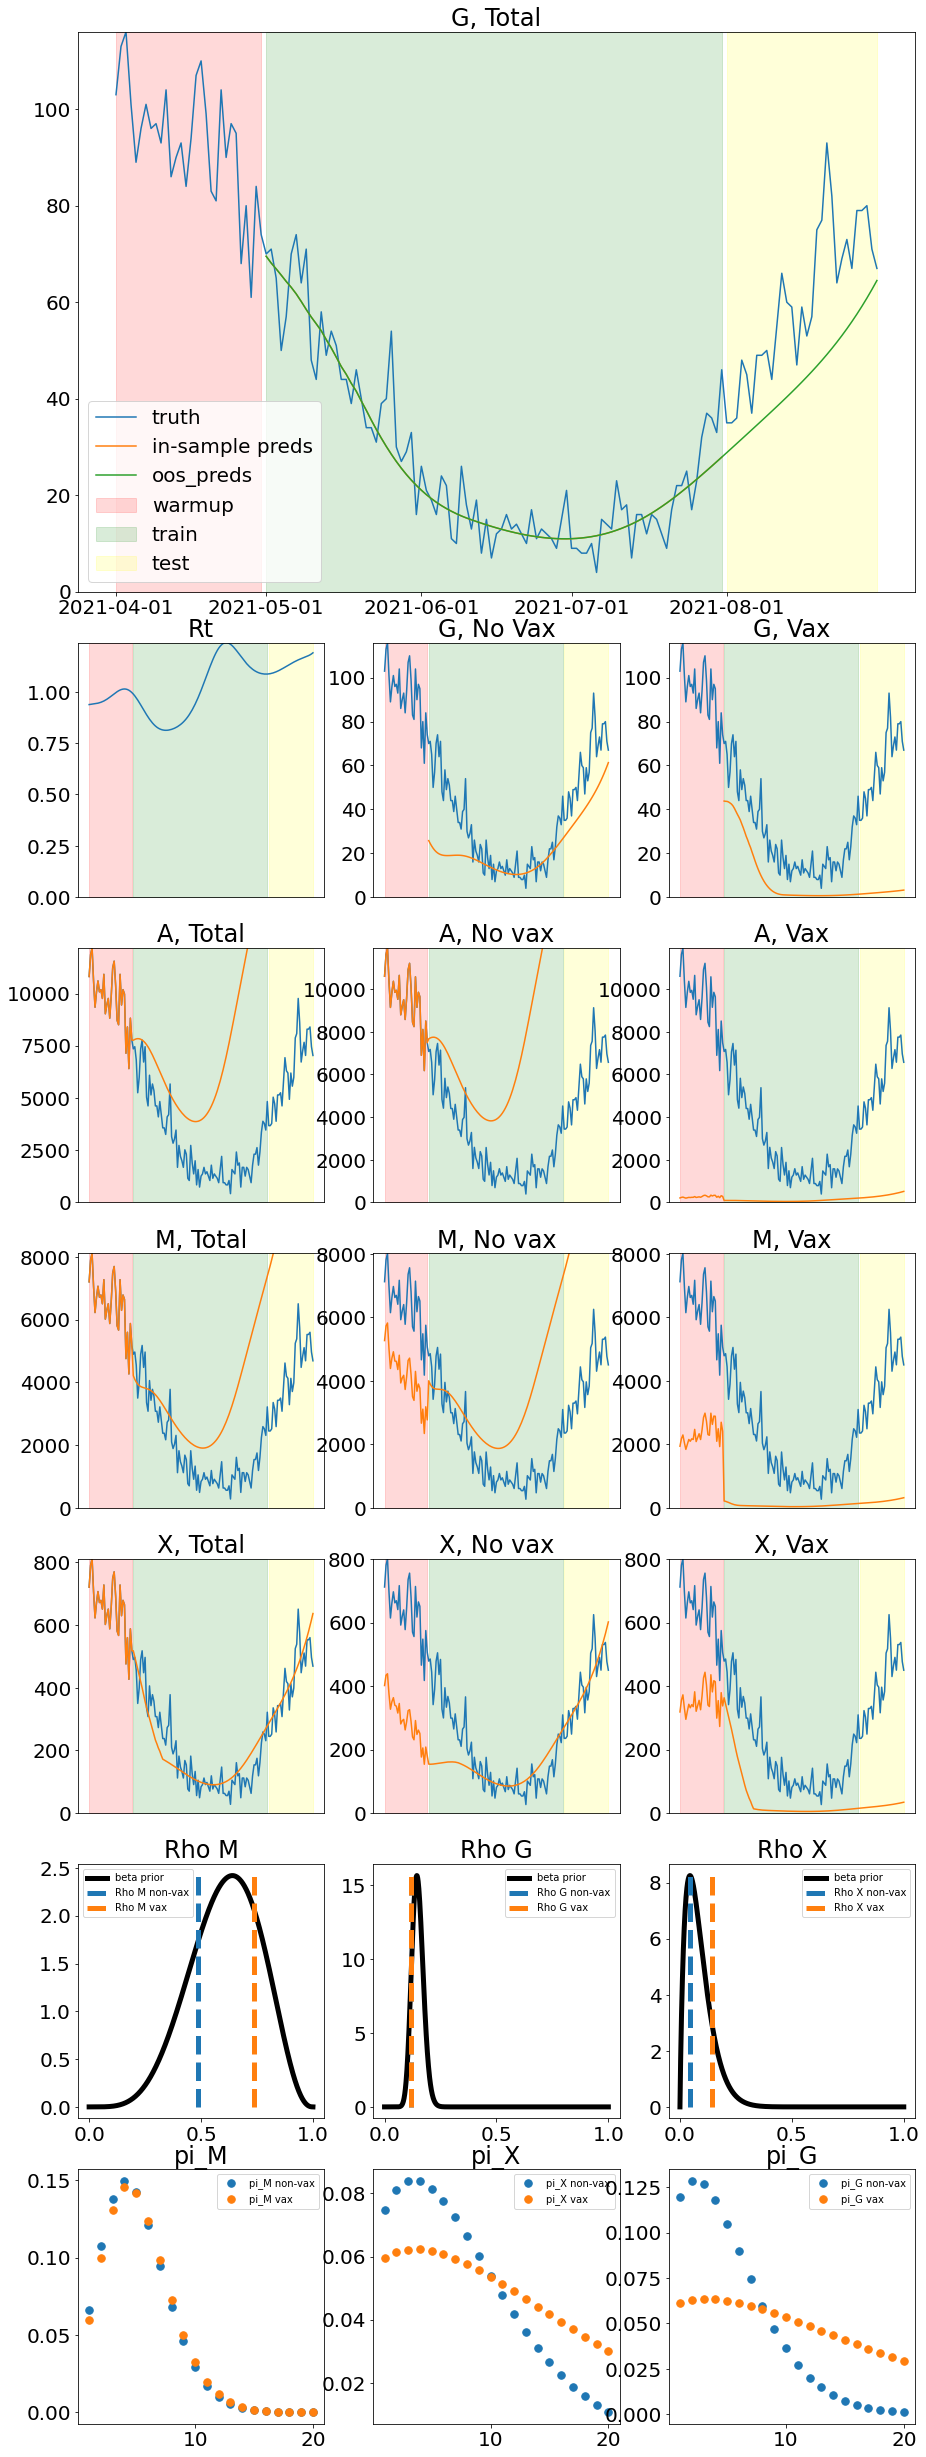

In [18]:
make_all_plots(df, model,
               alpha_bar_M, beta_bar_M,
               alpha_bar_X, beta_bar_X,
               alpha_bar_G, beta_bar_G,
                   warmup_start, warmup_end,
                   train_start, train_end,
                   test_start, test_end,
                   train_preds, test_preds,
                   vax_asymp_risk, vax_mild_risk, vax_extreme_risk,
                   forecasted_fluxes)

In [24]:
forecasted_fluxes[2][0].stack()[0] +forecasted_fluxes[2][1].stack()[0]

<tf.Tensor: shape=(), dtype=float32, numpy=721.0>

In [25]:
warmup_extreme

{1: array([ 8.418396,  9.482508, 10.01196 ,  8.97183 ,  8.066604,  8.777664,
         9.468144,  9.245376,  9.618714,  9.561888, 11.016096,  9.326184,
         9.89226 , 10.479798,  9.687888, 11.082036, 12.888792, 13.55046 ,
        12.415788, 10.520748, 10.44414 , 13.667472, 12.0771  , 13.330128,
        13.35054 ,  9.721824, 11.57856 ,  8.990058, 12.602016, 11.303796]),
 0: array([712.581604, 781.517492, 801.98804 , 698.02817 , 614.933396,
        663.222336, 697.531856, 662.754624, 669.381286, 641.438112,
        716.983904, 592.673816, 620.10774 , 640.520202, 578.312112,
        646.917964, 736.111208, 756.44954 , 680.584212, 570.479252,
        556.55586 , 714.332528, 617.9229  , 665.669872, 651.64946 ,
        466.278176, 548.42144 , 418.009942, 575.397984, 506.696204])}